# 7: Demonstration of distribution reweighting

* Reweighting in HEP is used to minimize difference between real data and Monte-Carlo simulation.
* Known process is used, for which real data can be obtained.
* Target of reweighting: assign weights to MC such that MC and real data distributions coincide.

**hep_ml.reweight** contains methods to reweight distributions.
Typically we use reweighting of monte-carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions: `original` and `target`, the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide.

Here we have a __toy example__ without a real physics meaning.

Pay attention: equality of distibutions for each feature $\neq$ equality of multivariate distributions.

All samples are divided into **training** and **validation** part. Training part is used to fit reweighting rule and test part is used to estimate reweighting quality.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import uproot
from hep_ml import reweight
from matplotlib import pyplot as plt

### Downloading data

In [2]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2019/MC_distribution.root',
                            httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                            ) as original_file:
    original_tree = original_file['tree']
    original = original_tree.arrays(library='pd')
with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2019/RD_distribution.root',
                          httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                          ) as target_file:
    target_tree = target_file['tree']
    target = target_tree.arrays(library='pd')
original_weights = np.ones(len(original))

### prepare train and test samples

* train part is used to train reweighting rule
* test part is used to evaluate reweighting rule comparing the following things:
    * Kolmogorov-Smirnov distances for 1d projections
    * n-dim distibutions using ML (see below).

In [3]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))

In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

## Original distributions
KS = Kolmogorov-Smirnov distance: a measure of how well two distributions agree, the lower the distance, the better the agreement. In this case we want a low KS value.

In [5]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.5203540728277889


KS over  pt_b  =  0.21639364439970188


KS over  pt_phi  =  0.4020113592414034


KS over  vchi2_b  =  0.40466385087324064


KS over  mu_pt_sum  =  0.21639364439970188


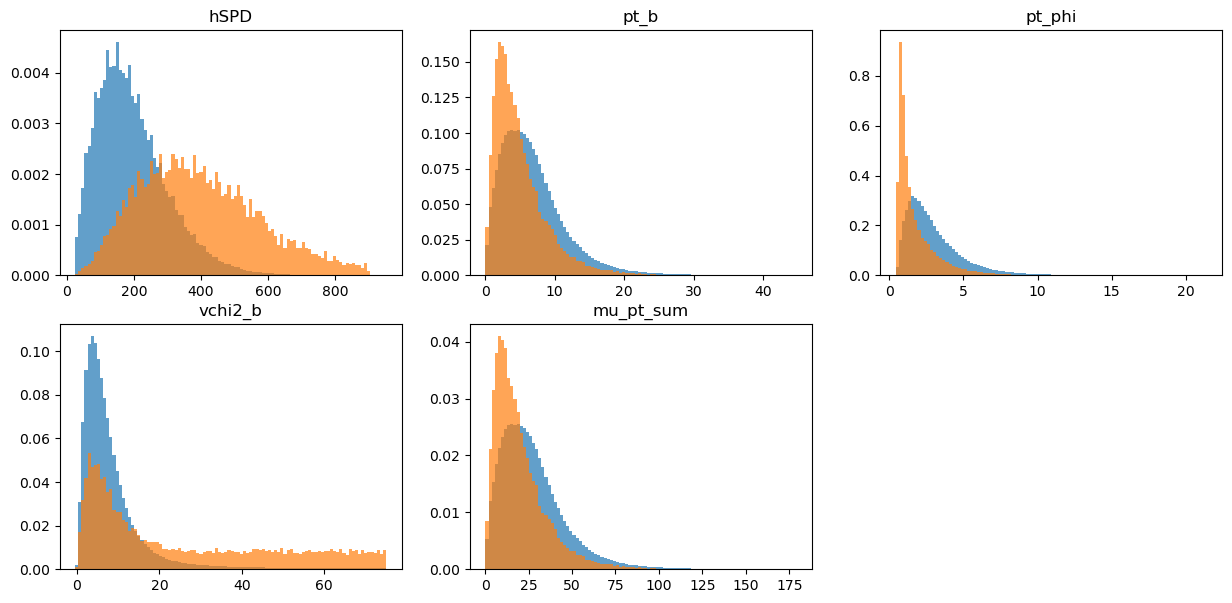

In [6]:
draw_distributions(original, target, original_weights)

### train part of original distribution

KS over  hSPD  =  0.5213593233830744


KS over  pt_b  =  0.21920619900333893


KS over  pt_phi  =  0.40479750248768276


KS over  vchi2_b  =  0.4051449253668853


KS over  mu_pt_sum  =  0.21920619900333893


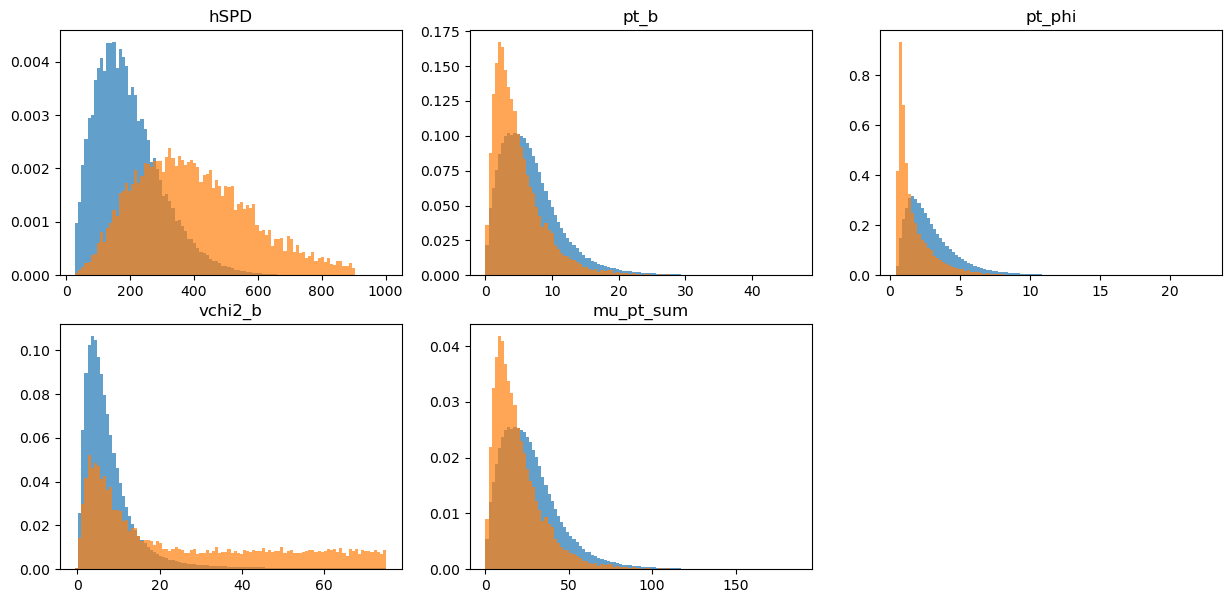

In [7]:
draw_distributions(original_train, target_train, original_weights_train)

### test part for target distribution

KS over  hSPD  =  0.5189527640365713
KS over  pt_b  =  0.2089595773173551


KS over  pt_phi  =  0.3946819947769732
KS over  vchi2_b  =  0.40399063048018274


KS over  mu_pt_sum  =  0.2089595773173551


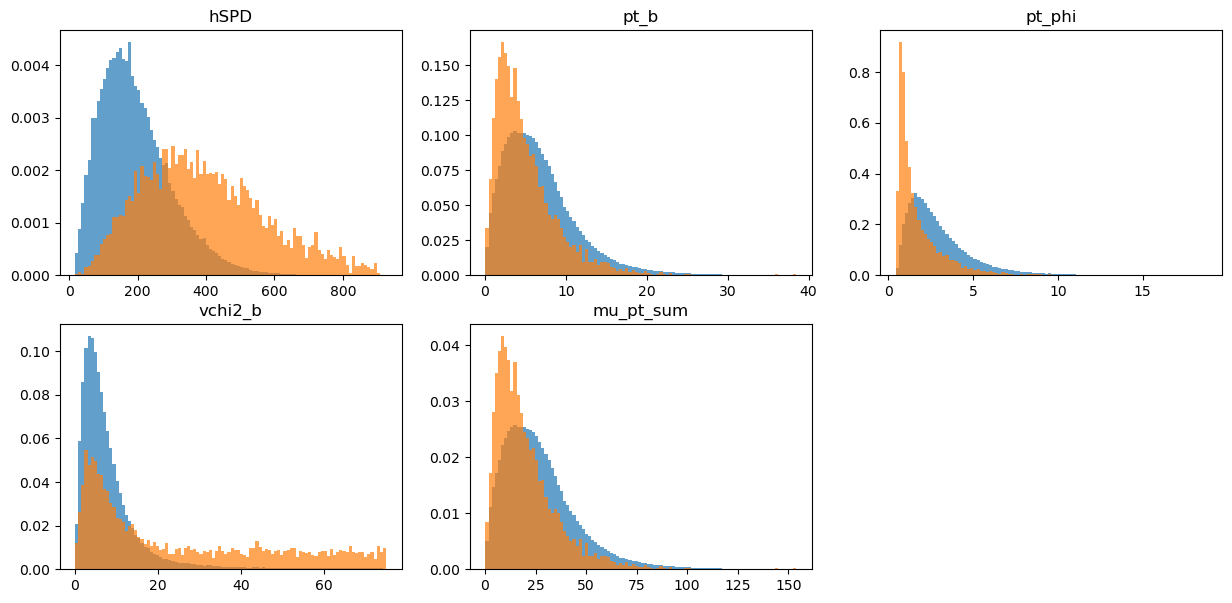

In [8]:
draw_distributions(original_test, target_test, original_weights_test)

### Bins-based reweighting in n dimensions

Typical way to reweight distributions is based on bins.


Usually histogram reweighting is used, in each bin the weight of original
distribution is multiplied by:

$m_{bin} = \frac{w_{target}}{w_{original}}$

where $w_{target}$ and $w_{original}$ are the total weight of events in each bin for target and original distributions.

1. Simple and fast!
2. Very few (typically, one or two) variables
3. Reweighting one variable may bring disagreement in others
4. Which variable to use in reweighting?

KS over  hSPD  =  0.405057123154817
KS over  pt_b  =  0.11086631644296868


KS over  pt_phi  =  0.27074011685835464


KS over  vchi2_b  =  0.3431452923252232
KS over  mu_pt_sum  =  0.11086631644296868


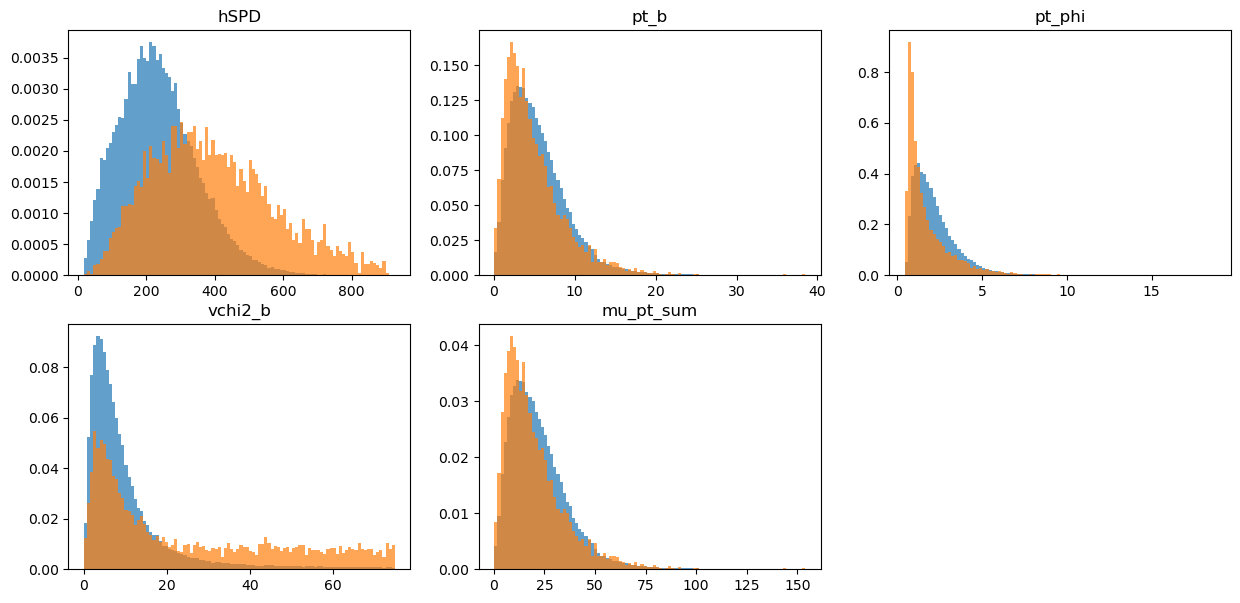

In [9]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train)

bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)

### Gradient Boosted Reweighter

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

A classifier is trained to discriminate between real data and MC. This means we are able to reweight in several variables rather than just one.
`GBReweighter` from `hep_ml` is able to handle many variables and requires less data (for the same performance).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

KS over  hSPD  =  0.030957383325373233
KS over  pt_b  =  0.02453712385921547


KS over  pt_phi  =  0.03469879539338025
KS over  vchi2_b  =  0.019061583339430754


KS over  mu_pt_sum  =  0.02453712385921547


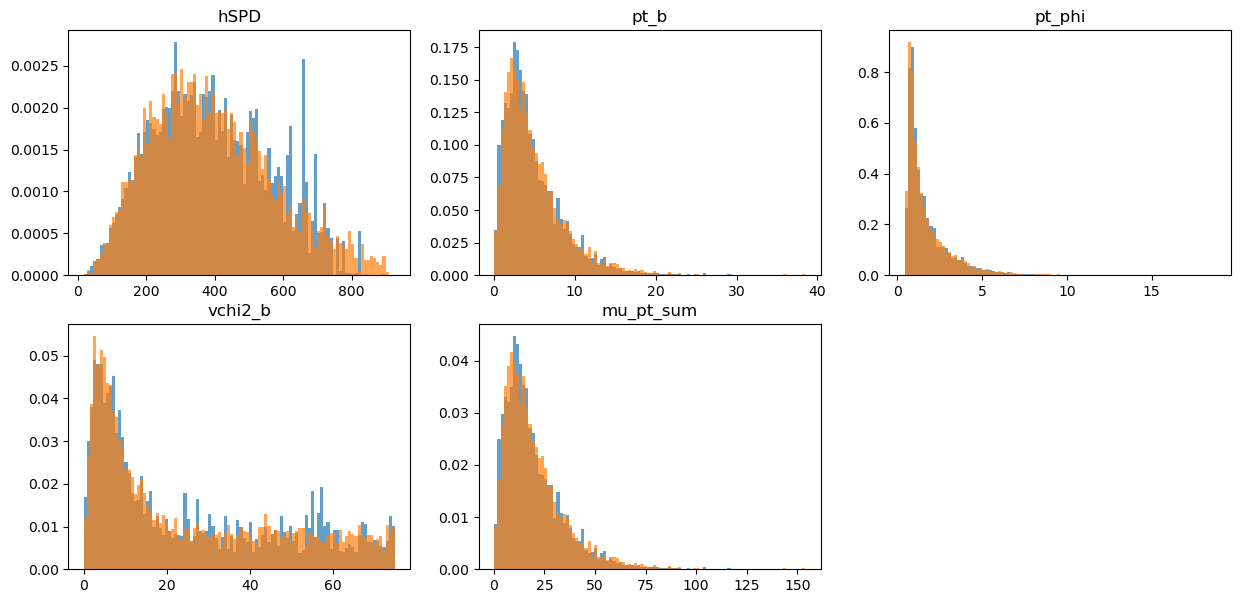

In [10]:
reweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                   gb_args={'subsample': 0.4})
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

## Comparing some simple expressions:
The most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).
Here we can check the KS distance in multidimensional distributions. (The lower the value, the better agreement of distributions.)

In [11]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = np.ones(len(col_target), dtype='float')
    print('No reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=original_weights_test, weights2=w_target))
    print('Bins reweight KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=bins_weights_test, weights2=w_target))
    print('GB Reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=gb_weights_test, weights2=w_target))

In [12]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.5189527640365713
Bins reweight KS: 0.405057123154817
GB Reweight   KS: 0.030957383325373233


In [13]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.0884694650253885


Bins reweight KS: 0.1138269436193508
GB Reweight   KS: 0.017300916779655118


In [14]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.3696907133004498


Bins reweight KS: 0.3372730315547786
GB Reweight   KS: 0.025230038525767995


In [15]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.47876745644457097


Bins reweight KS: 0.37528259330882197
GB Reweight   KS: 0.019433958526403616


In [16]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.4924638899466583


Bins reweight KS: 0.39974220667202987
GB Reweight   KS: 0.025179886968241694


### GB-discrimination
Let's check how well a classifier is able to distinguish these distributions.

For this puprose we split the data into train and test, then we train a classifier to distinguish between the real data and MC distributions.

We can use the ROC Area Under Curve as a measure of performance.
If ROC AUC = 0.5 on the test sample, the distibutions are identical, if ROC AUC = 1.0, they are ideally separable. So we want a ROC AUC as close to 0.5 as possible to know that we cannot separate the reweighted distributions.


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

data = np.concatenate([original_test, target_test])
labels = np.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9403367560985539


bins 0.9166386243534412


gb_weights 0.5031575990002415


## Great!

To the classifier, the two datasets seem now nearly undistingishable. Can we improve that? The `GBReweighter` is quite sensible to its hyperparameters, especially to `n_estimators`. Feel free to go back and increase it (to e.g. 250). What happens?

Answer: we get an even lower score! 0.49! Yeey! Or wait...

## What did just happen?

Our algorithm completely overfitted the distribution. The problem is that while for the classification we have a true label for each event, we do not have a true weight for each event, we just have a _true distribution_ so a "true local density" of the events. Or something like that.

As powerful as the `GBReweighter` is, as much does it need some care to be taken when choosing the hyperparameters as it can easily overfit. And, worse, the overfitting cannot be spotted so easily.

While this is a topic on its own, whatever you do with the `GBReweighter`, be sure to _really_ validate your result.

A hint of what may goes wrong is given when plotting the weights.

Text(0.5, 1.0, 'predicted weights')

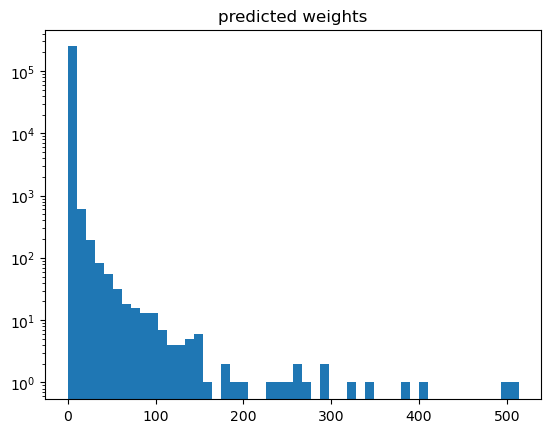

In [18]:
plt.hist(weights['gb_weights'], bins=50)
plt.yscale('log')
plt.title('predicted weights')

In [19]:
np.max(weights['gb_weights']), np.sum(weights['gb_weights'])

(513.213101537381, 68079.65269781963)

With such a high weight for a single event, this does not look desireable. And be aware of ad-hoc solutions: just clipping or removing weights is completely **wrong** as this would disturb the distribution completely.

A good way to proceed is to play around with the hyperparameters in order to avoid overfitting until the weights distribution looks "reasonable". Especially we don't want to have high weights in there if avoidable.

### How to tune

First find an appropriate number of estimators.

`max_depth` basically determines the order of correlations to be taken into account.

`n_estimators` has a tradeoff vs `learning_rate`. Increasing the former by a factor of n and reducing the latter by a factor of 1 / n keeps the reweighter with the same capability (e.g. overfitting) but tends to smooth out things. So use this at the end as more estimators take more time.

### Folding reweighter

`FoldingReweighter` uses k folding in order to obtain unbiased weights for the whole distribution.

The hyperparameters have been adjusted here. Be aware that `n_estimators=80` with `learning_rate=0.01` reads as `n_estimators=8` and `learning_rate=0.1` (in the above). So we greatly reduced the number of estimators.


KFold prediction using folds column


KS over  hSPD  =  0.3075395675056824


KS over  pt_b  =  0.18100233078140426


KS over  pt_phi  =  0.3085139214375579


KS over  vchi2_b  =  0.2983985388987025


KS over  mu_pt_sum  =  0.18100233078140426


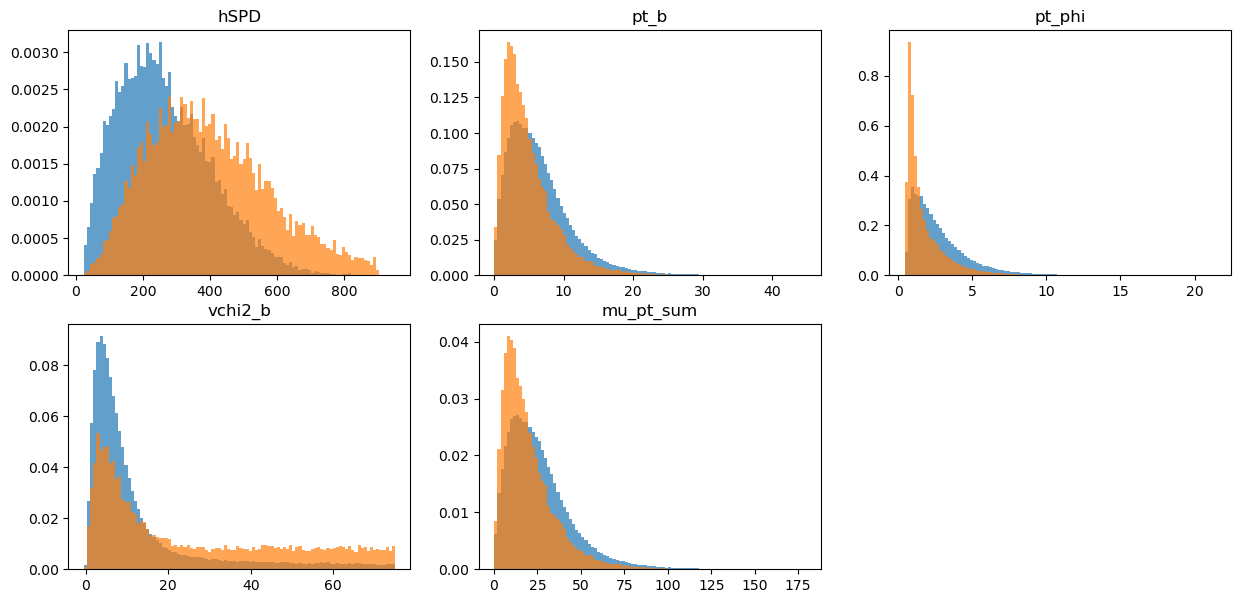

In [20]:
# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=80,
                                        learning_rate=0.01, max_depth=4, min_samples_leaf=100,
                                        gb_args={'subsample': 0.8})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; reweighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)

### GB discrimination for reweighting rule

In [21]:
data = np.concatenate([original, target])
labels = np.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['2-folding'] = folding_weights


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.6, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9367328699931634


2-folding 0.8270599644558083


Text(0.5, 1.0, 'predicted weights')

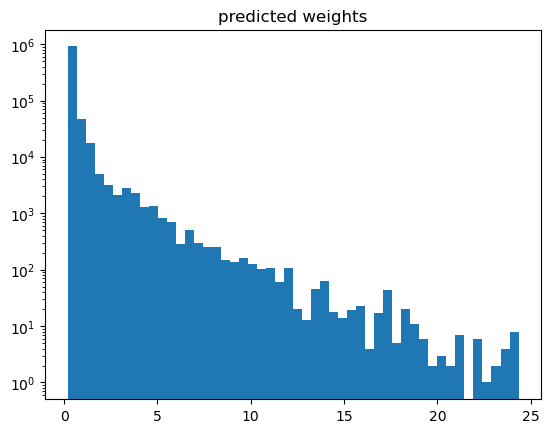

In [22]:
plt.hist(weights['2-folding'], bins=50)
plt.yscale('log')
plt.title('predicted weights')